# Exercise 2: MCMC for 2D Hardspheres

In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from numpy import cos, sin
from scipy.spatial.distance import cdist
colors = ['r','b','k','g','m','y']

## 1. Direct Sampling

In [2]:
def generate_points(n,L,sigma): #generates n points in the L by L square
    return np.array(np.split(L*np.random.rand(2*n),n))

In [3]:
def duplicate(X,L,sigma): #makes duplicates for points near edges, for periodic boundary conditions
    X1 = np.copy(X)
    
    X_temp = X[X[:,0] < sigma]; X_temp[:,0] += L; X1 = np.concatenate((X1,X_temp),axis=0)
    X_temp = X[X[:,1] < sigma]; X_temp[:,1] += L; X1 = np.concatenate((X1,X_temp),axis=0)
    X_temp = X[X[:,0] > L - sigma]; X_temp[:,0] -= L; X1 = np.concatenate((X1,X_temp),axis=0)
    X_temp = X[X[:,1] > L - sigma]; X_temp[:,1] -= L; X1 = np.concatenate((X1,X_temp),axis=0)

    X_temp = X[(X[:,0] < sigma)*(X[:,1] < sigma)];
    X_temp[:,0] += L; X_temp[:,1] += L; X1 = np.concatenate((X1,X_temp),axis=0)
    X_temp = X[(X[:,0] < sigma)*(X[:,1] > L - sigma)]; 
    X_temp[:,0] += L; X_temp[:,1] -= L; X1 = np.concatenate((X1,X_temp),axis=0)
    X_temp = X[(X[:,0] > L - sigma)*(X[:,1] < sigma)]; 
    X_temp[:,0] -= L; X_temp[:,1] += L; X1 = np.concatenate((X1,X_temp),axis=0)
    X_temp = X[(X[:,0] > L - sigma)*(X[:,1] > L - sigma)]; 
    X_temp[:,0] -= L; X_temp[:,1] -= L; X1 = np.concatenate((X1,X_temp),axis=0)

    return(X1)

In [4]:
def direct_sampling(n,L,sigma): #direct sampling: repeatedly samples n points until they form a correct configuration
    test = False
    p = 0
    while not(test):
        X = generate_points(n,L,sigma)
        X1 = duplicate(X,L,sigma)
        dist = cdist(X1,X1)
        dist[dist==0] += np.max(dist)
        if np.min(dist) > 2*sigma:
            test = True
        p += 1
    return(X,p)

In [5]:
def plot2(X,L,sigma,title='',size=6): #makes plot of points (represented by filled circles)
    X_all = duplicate(X,L,sigma)
    fig, ax = plt.subplots(figsize=(size,size))
    ax.set_ylim([0, L])
    ax.set_xlim([0, L])
    for i, (x,y) in enumerate(X_all):
        ax.add_artist(plt.Circle((x,y), sigma))
    plt.title(title)
    plt.show()

In [6]:
n = 20
L = 4
sigma = 0.2
X,p = direct_sampling(n,L,sigma)

Density = 0.15707963267948966
Number of rejections = 15


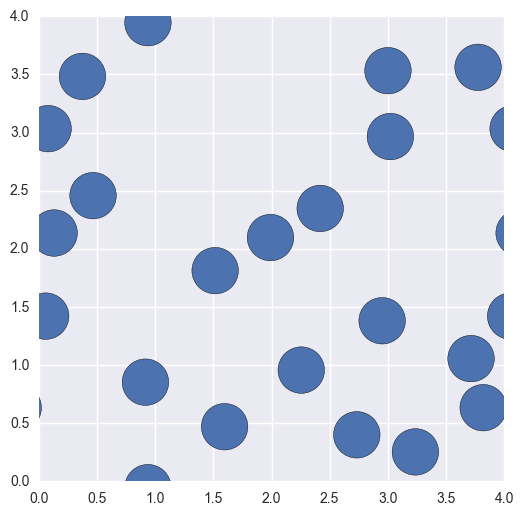

In [7]:
density = (n*(np.pi*(sigma**2)))/(L**2)
print("Density = " + str(density))
print("Number of rejections = " + str(p-1))
plot2(X,L,sigma)

We notice that even for low densities (around 0.15) there are a few hundred rejections before we sample a valid configuration. For higher densities, it is practically impossible to sample a configuration in reasonable time.

## 2. MCMC: periodic initial condition

In [8]:
def periodic_initial_condition(n,L): #regular periodic initial configuration
    m = int(np.sqrt(n))
    l = np.linspace(0,(m-1)/(m)*L,m)+L/(2*m)
    return np.array([(a,b) for a in l for b in l])

In [9]:
n = 4**2
L = 4
sigma = 0.2
X = periodic_initial_condition(n,L)

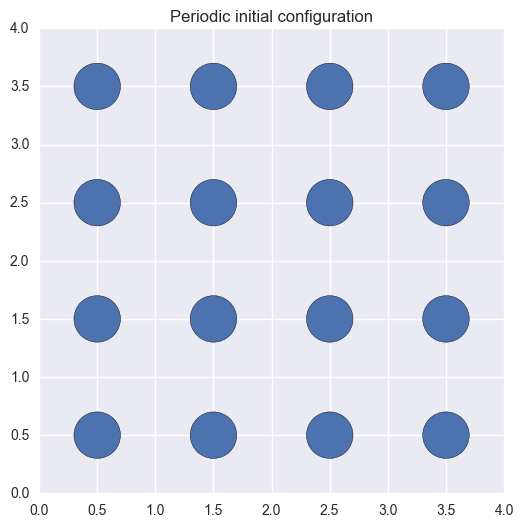

In [10]:
plot2(X,L,sigma,title='Periodic initial configuration')

We introduce as well a code that computes the number of points needed to achieve a target density, for a periodic square pattern, and one the computes the radius needed to achieve a target density given the number of points.

In [11]:
def number_of_points(density,L,sigma):
    #computes the needed number of points to achieve a given density, for given size of box and radius of spheres
    number = (density/np.pi)*(L/sigma)**2
    return ((int(np.sqrt(number)))**2)

In [12]:
def radius(density,L,n):
    return ( L * np.sqrt(density/(n*np.pi)) )

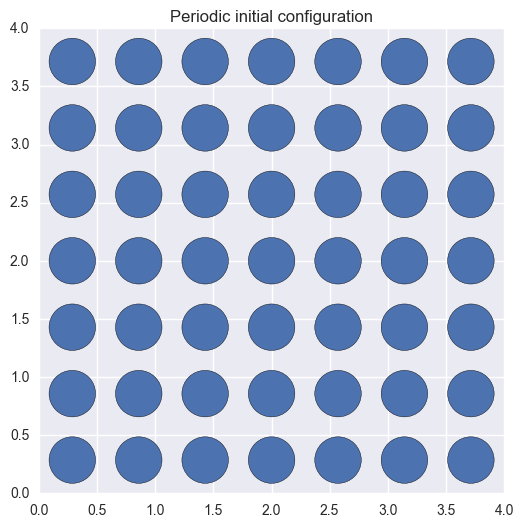

In [13]:
density = 0.5
L = 4
sigma = 0.2
X = periodic_initial_condition(number_of_points(density,L,sigma),L)
plot2(X,L,sigma,title='Periodic initial configuration')

## 3. MCMC for 2D Hard Spheres

We introduce a function takes the positions of the disks, and given the direction of the proposed move (theta), rotates the positions of the disks so that the direction of the proposed move is horizontal in the new coordinate system. This operation makes it easier to verify if the proposed move is accepted or rejected.

In [14]:
def rotate(X,theta):
    
    #this functions takes the positions of the disks, and given the direction of the proposed move (theta)
    #rotates the positions of the disks so that the direction of the proposed move is horizontal in the new coordinate
    #system
    
    O = np.array([[cos(-theta),-sin(-theta)],[sin(-theta),cos(-theta)]]) # orthogonal matrix of rotation
    
    return(np.dot(X,O.T))

To see effect of rotate function, uncomment and run the two next cells

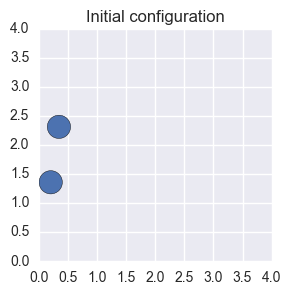

In [111]:
X,p = direct_sampling(2,4,0.2) # sample points
plot2(X,4,0.2,title='Initial configuration',size=3)

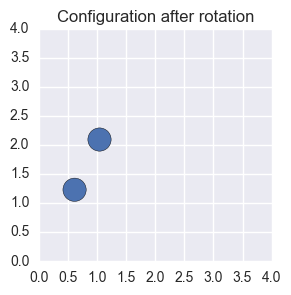

In [112]:
X1 = rotate(X,np.pi/10) # rotate points by angle
plot2(X1,4,0.2,title='Configuration after rotation',size=3)

In [17]:
def MCMC_step(X,L,sigma,stepsize):
    #This function represents an iteration of the MCMC algorithm
    #Inputs: a configuration and parameters of the problem
    #What it does: propose a move and test it
    #Output: the new configuration if the move is accepted, or the same as input if it is rejected
    
    #1- Pick a point
    I = np.random.randint(len(X))
    
    #2- Propose a move: direction and distance
    theta,step = (2*np.pi,stepsize) * np.random.rand(2)
    step = stepsize #comment this line if you want the distance to be random as well
    
    #3- Compute new configuration to test
    X_new = np.copy(X)
    X_new[I] += (step*cos(theta),step*sin(theta)) #X_new is the new configuration, that we will return if it passes all tests
    X_new[I,0] += (X_new[I,0]<0)*L - (X_new[I,0]>L)*L #adjusts coordinate if necessary, using periodic boundary conditions
    X_new[I,1] += (X_new[I,1]<0)*L - (X_new[I,1]>L)*L #adjusts coordinate if necessary, using periodic boundary conditions
    
    #4- Rotate points
    X1 = rotate(duplicate(X,L,2*sigma+step),theta)
    X_other = np.delete(X1,I,axis=0) #set of points other than the one that was picked

    #5- Check if there is a collision: reject if yes
    X_near = X_other[ np.squeeze(cdist(X_other,[X1[I]])) < step + 2*sigma ]
    if len(X_near)==0: # if all other points points are too far from the one that was picked, there will be no collision: accept
        return(X_new,True)
    
    #5.1 - First collision test
    X2 = X_near[ (X1[I,0] < X_near[:,0])*(X_near[:,0] < X1[I,0] + step) ]
    if (np.sum(np.abs(X2[:,1] - X1[I,1]) < 2*sigma) > 0):
        return(X,False)

    #5.2 - Second collision test    
    if (np.min( np.squeeze( cdist(X_near,[X1[I]+(step,0)]) ) ) < 2*sigma):
        return(X,False)
    
    #6- If the proposed move passed all tests: accept and return new positions
    return(X_new,True)

In [18]:
n = 4**2
L = 4
sigma = 0.2
X = periodic_initial_condition(n,L)

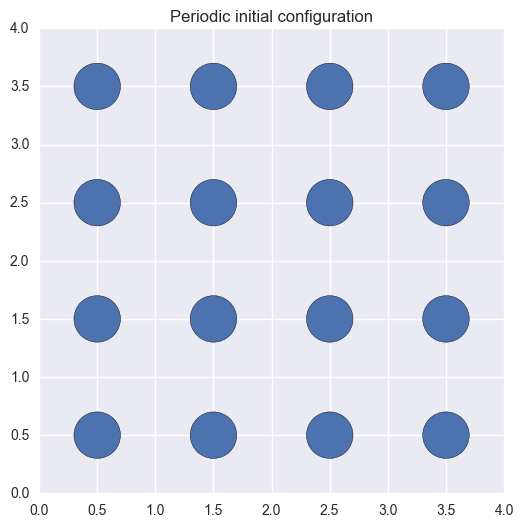

In [19]:
plot2(X,L,sigma,title='Periodic initial configuration')

Here we test the MCMC function: we run successive iterations of this function until we have an accepted move, and plot the result.

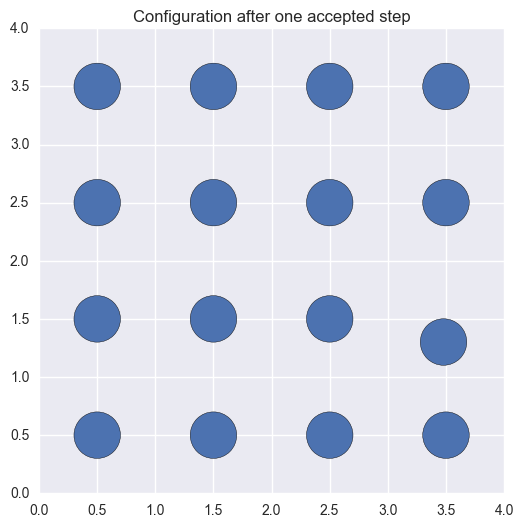

In [20]:
A = False
while not(A):
    X1,A = MCMC_step(X,L,sigma,sigma)
plot2(X1,L,sigma,title='Configuration after one accepted step')

Here we test the MCMC function: we run many iterations of this function, and plot the result.

In [21]:
X1 = np.copy(X)
iterations = 10000
delta = 2*sigma
S = 0
for t in range(iterations):
    X1,A = MCMC_step(X1,L,sigma,delta)
    S += A

Acceptance rate = 0.6947


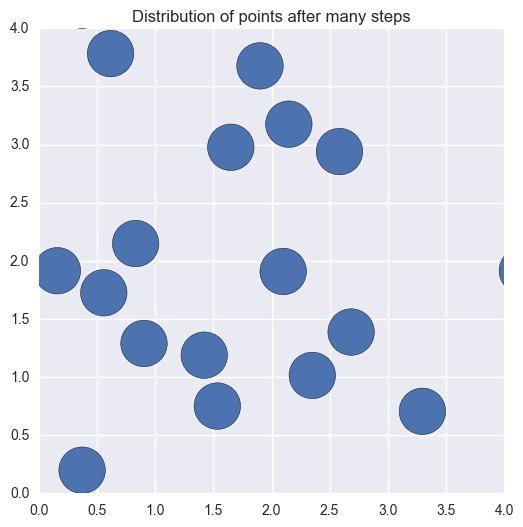

In [22]:
print('Acceptance rate = '+str(S/iterations))
plot2(X1,L,sigma,title='Distribution of points after many steps')

The following function runs the MCMC algorithm for a range of steps, and returns the optimal step according to the 1/2 thumb rule (asymptotic acceptance rate of 0.5)

In [23]:
def optimize_step(n,L,sigma,maximal=1,iterations = 10000):
    #finds optimal step size using 1/2 rule
    steps = np.linspace(0,maximal*sigma,10)
    rates = np.zeros(10)
    for i,step in enumerate(steps):
        S = 0
        X1 = periodic_initial_condition(n,L)
        for t in range(iterations):
            X1,A = MCMC_step(X1,L,sigma,step)
            S += A
        rates[i] = S/iterations
    return( steps[np.argmin(np.abs(rates-0.5))] )

### Density at 0.25

In [46]:
density = 0.25
L = 20
n = 16**2
sigma1 = radius(density,L,n)
X1 = periodic_initial_condition(n,L)

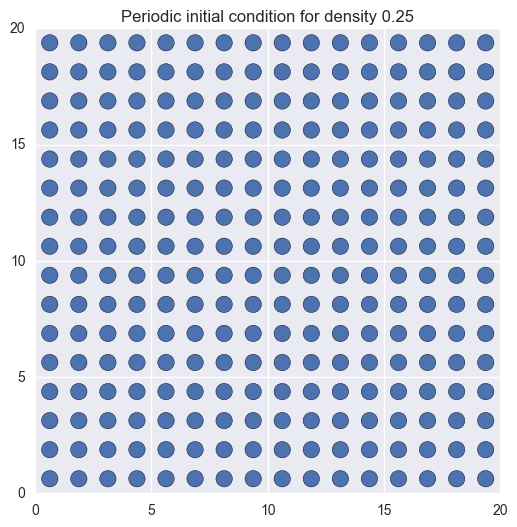

In [25]:
plot2(X1,L,sigma,title='Periodic initial condition for density 0.25')

In [26]:
step = optimize_step(n,L,sigma1,maximal=2,iterations=25000)
print("The optimal step is "+str(step))

The optimal step is 0.47015798629


In [27]:
Y1 = np.copy(X1)
iterations = 500000
S = 0
for t in range(iterations):
    Y1,A = MCMC_step(Y1,L,sigma1,step)
    S += A

Acceptance rate = 0.511908


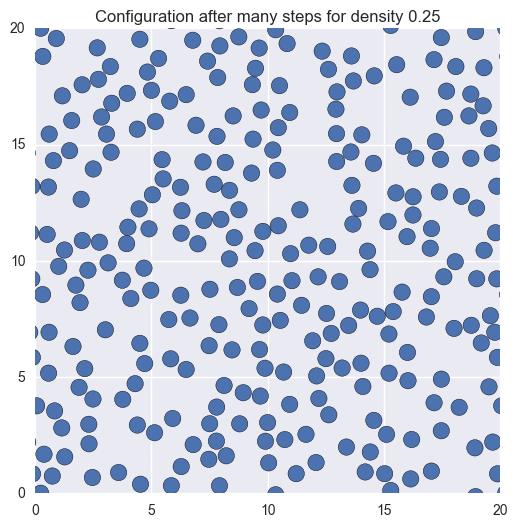

In [28]:
print('Acceptance rate = '+str(S/iterations))
plot2(Y1,L,sigma1,title='Configuration after many steps for density 0.25')

### Density at 0.5

In [47]:
density = 0.50
L = 20
n = 16**2
sigma2 = radius(density,L,n)
X2 = periodic_initial_condition(n,L)

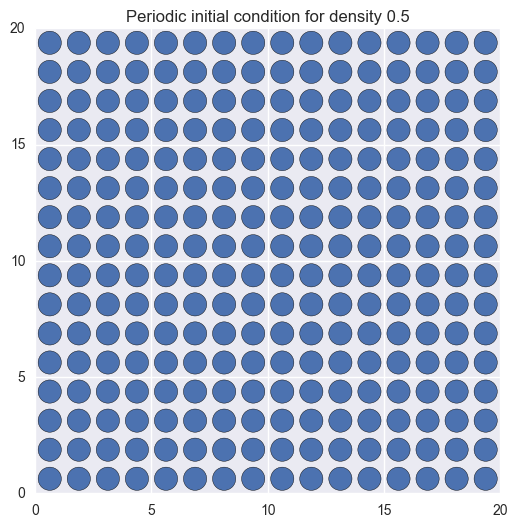

In [30]:
plot2(X2,L,sigma2,title='Periodic initial condition for density 0.5')

In [31]:
step = optimize_step(n,L,sigma2,maximal=1,iterations=25000)
print("The optimal step is "+str(step))

The optimal step is 0.166225950167


In [32]:
Y2 = np.copy(X2)
iterations = 500000
S = 0
for t in range(iterations):
    Y2,A = MCMC_step(Y2,L,sigma2,step)
    S += A

Acceptance rate = 0.52036


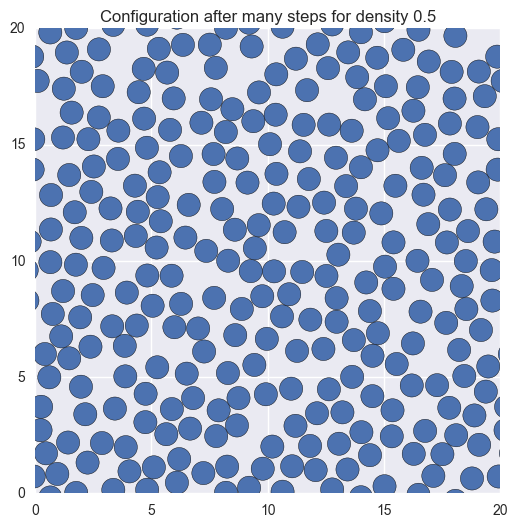

In [33]:
print('Acceptance rate = '+str(S/iterations))
plot2(Y2,L,sigma2,title='Configuration after many steps for density 0.5')

### Density at 0.72

In [48]:
density = 0.72
L = 20
n = 16**2
sigma3 = radius(density,L,n)
X3 = periodic_initial_condition(n,L)

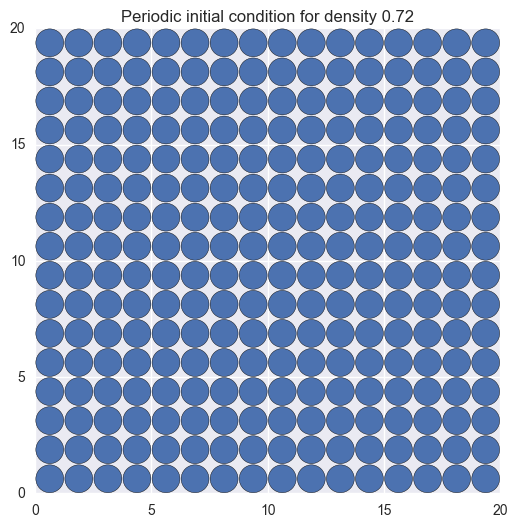

In [35]:
plot2(X3,L,sigma3,title='Periodic initial condition for density 0.72')

In [36]:
step = optimize_step(n,L,sigma3,maximal=0.2,iterations=25000)
print("The optimal step is "+str(step))

The optimal step is 0.0398942280401


In [37]:
Y3 = np.copy(X3)
iterations = 500000
S = 0
for t in range(iterations):
    Y3,A = MCMC_step(Y3,L,sigma3,step)
    S += A

Acceptance rate = 0.574836


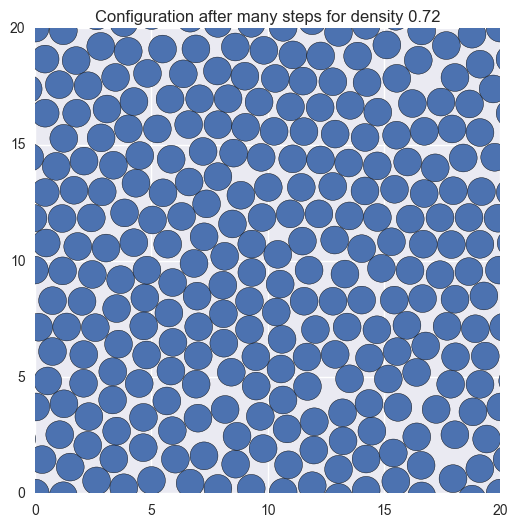

In [38]:
print('Acceptance rate = '+str(S/iterations))
plot2(Y3,L,sigma3,title='Configuration after many steps for density 0.72')

We observe that even for very dense configurations, the algorithm outputs a distribution quite different from the initial square pattern. In fact, we observe the formation of local hexagonal patterns, which in fact represent the maximal packing patterns.

To characterize phases, we need to characterize the density-pressure isotherms: that is for fixed temperature, plot the value of the pressure as a function of density.

The problem then resides in computing the pressure for our system. We can do it via the force definition: that is, the pressure is the force exerced on an element of surface, which in 2D is a line (we can choose the right edge of the $L\times L$ square for example). The force can be viewed as the transfer of momentum from moving particles to the surface element per unit of time. Therefore, we first compute this force by running the algorithm for many iterations and compute the momentum transfered by particles that will hit the surface element, then divide by number of iterations (which is proportional to the time). Dividing by the length of the edge will give us the pressure for this density, at fixed temperature. Note that for this we will need to change boundary conditions and have a number of particles confined in a box of finite size (in order to be able to define the pressure).

## 4. Orientational order parameter

In [39]:
def neighbouring_matrix(X,sigma): #returns matrix M such that M_ij = d(x_i,x_j) if i and j are neighbours and 0 otherwise
    d = cdist(X,X)
    d[d > 2.8*sigma] = 0
    return (d)

In [40]:
def orientational_order(X,L,sigma): #computes and returns orientational order parameters for all points of a given configuration
    X1 = duplicate(X,L,2.8*sigma)
    NM = neighbouring_matrix(X1,sigma)
    nb_neigh = np.sum(NM>0,axis=0)
    Psi = np.zeros((len(X),2))
    for i in range(len(X)):
        x = X[i]
        l = X1[NM[i]>0]
        d = NM[i][NM[i]>0]
        new = (l-x)/ np.expand_dims(d,axis=1)
        orient_order = np.mean((new[:,0]+new[:,1]*1j)**6,axis=0)
        Psi[i] = (np.real(orient_order),np.imag(orient_order))
    return(Psi,nb_neigh[:len(X)])

D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)


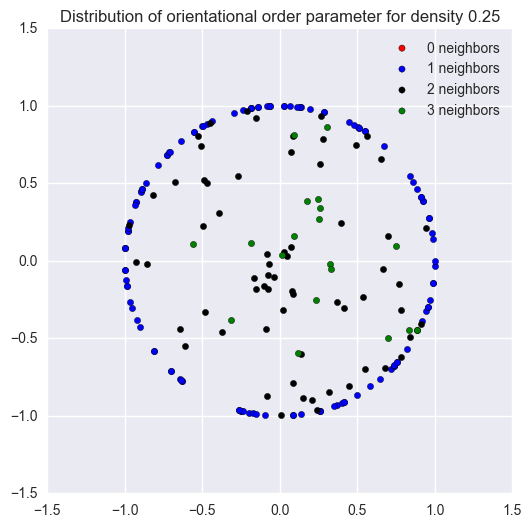

In [49]:
Psi, nb_neigh = orientational_order(Y1,L,sigma1)
fig, ax = plt.subplots(figsize=(6,6))
ax.set_ylim([-1.5, 1.5])
ax.set_xlim([-1.5, 1.5])
for i, nb in enumerate(set(nb_neigh)):
    psi = Psi[nb_neigh == nb]
    plt.scatter(psi[:,0],psi[:,1],c=colors[i%6],label=str(nb)+' neighbors')
plt.legend(loc='best')
plt.title('Distribution of orientational order parameter for density 0.25')
plt.show()

We observe that for a low density ($0.25$) a great portion of the particles have only one neighbour, which is normal since the particles are very diluted, and for these points the orientational order parameter is on the unit circle. There are a few points with 2 neighbours, and few with 3 neighbours, and we observe no particular pattern for these.

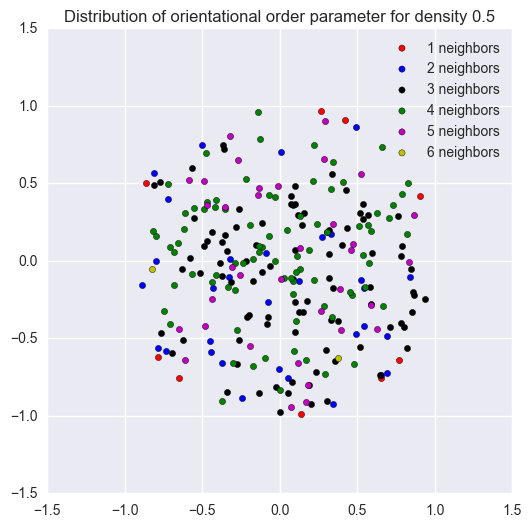

In [50]:
Psi, nb_neigh = orientational_order(Y2,L,sigma2)
fig, ax = plt.subplots(figsize=(6,6))
ax.set_ylim([-1.5, 1.5])
ax.set_xlim([-1.5, 1.5])
for i, nb in enumerate(set(nb_neigh)):
    psi = Psi[nb_neigh == nb]
    plt.scatter(psi[:,0],psi[:,1],c=colors[i%6],label=str(nb)+' neighbors')
plt.legend(loc='best')
plt.title('Distribution of orientational order parameter for density 0.5')
plt.show()

With a medium density ($0.5$), we have now particles with more neighbours, 3, 4, 5 (for some simulation we get even particles with 6 neighbours). The orientational order parameter is still more or less uniformy distributed in the unit disk.

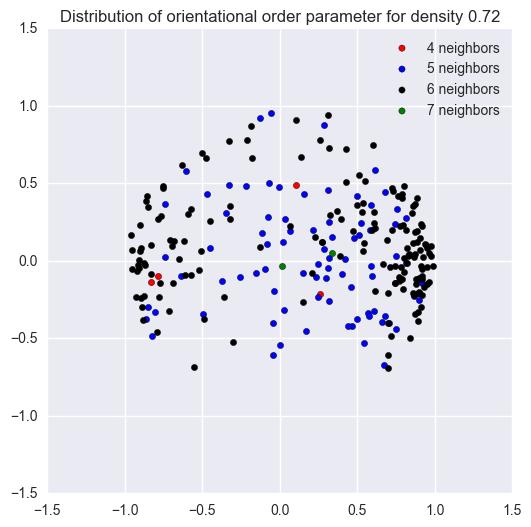

In [51]:
Psi, nb_neigh = orientational_order(Y3,L,sigma3)
fig, ax = plt.subplots(figsize=(6,6))
ax.set_ylim([-1.5, 1.5])
ax.set_xlim([-1.5, 1.5])
for i, nb in enumerate(set(nb_neigh)):
    psi = Psi[nb_neigh == nb]
    plt.scatter(psi[:,0],psi[:,1],c=colors[i%6],label=str(nb)+' neighbors')
plt.legend(loc='best')
plt.title('Distribution of orientational order parameter for density 0.72')
plt.show()

For very high density ($0.72$) we notice some interesting changes. First, most points have now 5 or more neighbours, which is normal since the system is very dense. More interestingly, many of the points have 6 neighbours, and for these we notice that the orientational order parameter is densely located near the edges of the unit disk: we no more have a uniform distribution on the whole disk.

We can interpret this by the fact that high density states favor the appearance of local regular hexagonal patterns (which we observed in Q3). In fact, let's consider a particle with 6 neighbours that are distributed on a tight hexagon around it, and label the rightmost neighbour $0$, then label the 5 others $1$ to $5$ in a counter-clockwise order. Therefore, particle $0$ is located at an angle $\phi_0 = \alpha \in [-\pi/6,\pi/6]$ since it is the rightmost point in a regular hexagon, then any particle $k$ is located at angle $\phi_k = \alpha + k \pi/3$ since we have a tight hexagon. Therefore, $6\phi_k = 6\alpha + 2k \pi$ and $e^{6i\alpha}=e^{6i\phi_k}$, which means that all the complex exponentials in the order parameter formula are in fact the same, therefore the orientational order parameter for this configuration is $e^{6i\alpha}$ which means that it is on the unit circle. Of course, since we relaxed the neighbour constraint in the formula and since the packing is not tight, we have some deviations and some points are note exactly on the unit circle, but they are concentrated near it.